In [1]:
import sys
print ( sys.path )

import numpy as np
import pandas as pd
import h5py
import matplotlib as mpl
import matplotlib.pyplot as plt
import mplhep
from matplotlib.colors import LogNorm
from joblib import dump, load
import scipy.stats
plt.style.use(mplhep.style.CMS)
import matplotlib.font_manager
mpl.rcParams.update(
    {'font.size': 24,
     'font.family': 'sans-serif',
     'legend.fontsize': 24,
     'axes.labelsize': 24,
     'axes.labelpad': 10,
     'xtick.labelsize': 22,
     'ytick.labelsize': 22 
    }
    )

['/cvmfs/sft.cern.ch/lcg/releases/condor/8.9.11-eadc8/x86_64-centos7-gcc11-opt/lib/python3', '/cvmfs/sft.cern.ch/lcg/views/LCG_104a_swan/x86_64-centos7-gcc11-opt/lib/python3.9/site-packages/itk', '/cvmfs/sft.cern.ch/lcg/views/LCG_104a_swan/x86_64-centos7-gcc11-opt/python', '/cvmfs/sft.cern.ch/lcg/views/LCG_104a_swan/x86_64-centos7-gcc11-opt/lib', '', '/cvmfs/sft.cern.ch/lcg/views/LCG_104a_swan/x86_64-centos7-gcc11-opt/lib/python3.9/site-packages', '/srv/dask/lib', '/cvmfs/sft.cern.ch/lcg/releases/Python/3.9.12-9a1bc/x86_64-centos7-gcc11-opt/lib/python39.zip', '/cvmfs/sft.cern.ch/lcg/releases/Python/3.9.12-9a1bc/x86_64-centos7-gcc11-opt/lib/python3.9', '/cvmfs/sft.cern.ch/lcg/releases/Python/3.9.12-9a1bc/x86_64-centos7-gcc11-opt/lib/python3.9/lib-dynload', '/eos/user/m/malvesga/.local/lib/python3.9/site-packages', '/cvmfs/sft.cern.ch/lcg/releases/Python/3.9.12-9a1bc/x86_64-centos7-gcc11-opt/lib/python3.9/site-packages', '/cvmfs/sft.cern.ch/lcg/views/LCG_104a_swan/x86_64-centos7-gcc11-op

In [2]:
from processing import lumi_periods_2017, lumi_periods_2018

lepton_type = 'muon'
# lepton_type = 'electron'

# data_sample = '2017'
data_sample = '2018'

save_figures = True

{'muon': {'2017B': 4.799881474, '2017C1': 5.785813941, '2017C2': 3.786684323, '2017D': 4.247682053, '2017E': 9.312832062, '2017F1': 1.738905587, '2017F2': 8.125575961, '2017F3': 3.674404546}, 'electron': {'2017B': 4.594096155565198, '2017C1': 5.521298099245362, '2017C2': 3.6135646891210857, '2017D': 4.0518639103567, '2017E': 8.906848461089172, '2017F1': 1.6584516422062712, '2017F2': 7.749629938012412, '2017F3': 3.504400870870218}}
Luminosity 2017 muon: 41.471779946999995
Luminosity 2017 electron: 39.60015376646642
{'muon': {'2018A': 12.103512482, '2018B1': 6.3798061, '2018B2': 0.40141386, '2018C': 6.524227381, '2018D1': 19.877577, '2018D2': 10.414449}, 'electron': {'2018A': 12.103189833, '2018B1': 6.379806, '2018B2': 0.40141386, '2018C': 6.527251329, '2018D1': 19.876804, '2018D2': 10.414449}}
Luminosity 2018 muon: 55.700985822999996
Luminosity 2018 electron: 55.702914022


### Event selection

In [3]:
def tau21_ddt_calculation(df, lepton_type, label_jet=None):
    
    label_jet_ = "_nom"
    if label_jet is not None: label_jet_ = label_jet
        
    jet0_tau21_ = ( df.loc[ :, "jet0_tau2"] / df.loc[ :, "jet0_tau1"] )
    
    M_ = 0. ##M is the slope of the tau21 versus rhoprime1
    rhoprime1_ = np.log((((df.loc[ :, "jet0_corrmass" + label_jet_])**2)/(df.loc[ :, "jet0_pt" + label_jet_])))
    if lepton_type == 'muon':
        #M_ = -0.06549078537121121 
        M_ = -0.06985584011450555
    if lepton_type == 'electron':
        #M_ = -0.05984253738963618    
        M_ = -0.057877831836395534
    jet0_tau21_ddt_ = jet0_tau21_ - (M_*rhoprime1_)
    
    return jet0_tau21_, rhoprime1_, jet0_tau21_ddt_

In [4]:
def select_events( df_events, lepton_type, max_num_tracks = -1, label_jet=None, label_muon=None, label_electron=None ):

    max_num_tracks_ = max_num_tracks
    
#     label_jet_ = "_nom"
#     label_muon_ = "_nom"
#     label_WLep_ = "_nom"
#     label_WW_ = "_nom"
    label_jet_ = "_nom"
    if label_jet is not None: label_jet_ = label_jet
        
    label_muon_ = "_nom"
    if label_muon is not None: label_muon_ = label_muon
        
    label_electron_ = "_nom"
    if label_electron is not None: label_electron_ = label_electron
        
    label_WLep_ = "_nom"
    if label_muon is not None:
        label_WLep_ = label_muon
    elif label_electron is not None:
        label_WLep_ = label_electron
        
    label_WW_ = "_nom"
    if label_jet is not None:
        label_WW_ = label_jet
    elif label_muon is not None:
        label_WW_ = label_muon
    elif label_electron is not None:
        label_WW_ = label_electron
        
    label_xiCMS_ = "_nom"
    if label_jet is not None:
        label_xiCMS_ = label_jet
    elif label_muon is not None:
        label_xiCMS_ = label_muon
    elif label_electron is not None:
        label_xiCMS_ = label_electron
    
    lepton_var_pt_ = ""
    lepton_var_phi_ = ""
    lepton_var_eta_ = ""
    if lepton_type == 'muon':
        lepton_var_pt_ = "muon0_pt"
        lepton_var_phi_ = "muon0_phi"
        lepton_var_eta_ = "muon0_eta"
    elif lepton_type == 'electron':
        lepton_var_pt_ = "electron0_pt"
        lepton_var_phi_ = "electron0_phi"
        lepton_var_eta_ = "electron0_eta"
           
    deltaPhi_jet_lep_ = ( df_events.loc[ :, "jet0_phi"] - df_events.loc[ :, lepton_var_phi_ ] )
    msk_dphi_ = ( deltaPhi_jet_lep_ < -np.pi )
    deltaPhi_jet_lep_.loc[ msk_dphi_ ] = deltaPhi_jet_lep_.loc[ msk_dphi_ ] + 2*np.pi
    msk_dphi_ = ( deltaPhi_jet_lep_ >= np.pi )
    deltaPhi_jet_lep_.loc[ msk_dphi_ ] = deltaPhi_jet_lep_.loc[ msk_dphi_ ] - 2*np.pi
    
    deltaEta_jet_lep_ = ( df_events.loc[ :, "jet0_eta"] - df_events.loc[ :, lepton_var_eta_ ] )
    deltaR_jet_lep_ = np.sqrt( ( deltaPhi_jet_lep_ ) ** 2 + ( deltaEta_jet_lep_ ) ** 2 )
    
    deltaPhi_jet_met_ = ( df_events.loc[ :, "jet0_phi"] - df_events.loc[ :, "met_phi"] )
    msk_dphi_ = ( deltaPhi_jet_met_ < -np.pi )
    deltaPhi_jet_met_.loc[ msk_dphi_ ] = deltaPhi_jet_met_.loc[ msk_dphi_ ] + 2*np.pi
    msk_dphi_ = ( deltaPhi_jet_met_ >= np.pi )
    deltaPhi_jet_met_.loc[ msk_dphi_ ] = deltaPhi_jet_met_.loc[ msk_dphi_ ] - 2*np.pi
    
    deltaPhi_jet_Wlep_ = ( df_events.loc[ :, "jet0_phi"] - df_events.loc[ :, "WLeptonicPhi"] )
    msk_dphi_ = ( deltaPhi_jet_Wlep_ < -np.pi )
    deltaPhi_jet_Wlep_.loc[ msk_dphi_ ] = deltaPhi_jet_Wlep_.loc[ msk_dphi_ ] + 2*np.pi
    msk_dphi_ = ( deltaPhi_jet_Wlep_ >= np.pi )
    deltaPhi_jet_Wlep_.loc[ msk_dphi_ ] = deltaPhi_jet_Wlep_.loc[ msk_dphi_ ] - 2*np.pi

    jet0_tau21_ = ( df_events.loc[ :, "jet0_tau2"] / df_events.loc[ :, "jet0_tau1"] )
    
    M_ = 0. ##M is the slope of the tau21 versus rhoprime1
    rhoprime1_ = np.log((((df_events.loc[ :, "jet0_corrmass" + label_jet_])**2)/(df_events.loc[ :, "jet0_pt" + label_jet_])))
    if lepton_type == 'muon':
        #M_ = -0.06549078537121121 
        M_ = -0.06985584011450555
    if lepton_type == 'electron':
        #M_ = -0.05984253738963618    
        M_ = -0.057877831836395534    
    jet0_tau21_ddt_ = jet0_tau21_ - (M_*rhoprime1_)

    msk_All_ = np.full( df_events.shape[0], True, dtype=bool )
    
    msk_lep_ = None
    if lepton_type == 'muon':
        msk_lep_ = ( ( df_events.loc[ :, "muon0_pt" + label_muon_ ] >= 50.0 ) &
                     ( np.abs( df_events.loc[ :, "muon0_eta"] ) <= 2.4 ) & 
                     ( df_events.loc[ :, "muon0_iso"] <= 0.10 ) )
    elif lepton_type == 'electron':
        msk_lep_ = ( ( df_events.loc[ :, "electron0_pt" + label_electron_ ] >= 50.0 ) &
                     ( np.abs( df_events.loc[ :, "electron0_eta"] ) <= 2.4 ) )
        
    msk_jet_ = ( ( df_events.loc[ :, "jet0_pt" + label_jet_] >= 220.0 ) &
                 ( np.abs( df_events.loc[ :, "jet0_eta"] ) <= 2.4 ) )
    
    msk_jet_lep_ = ( deltaR_jet_lep_ >= np.pi/2 )
    
    if lepton_type == 'muon':
        msk_met_ = ( df_events.loc[ :, "met"] >= 40.0 )
    elif lepton_type == 'electron':
        msk_met_ = ( df_events.loc[ :, "met"] >= 100.0 )  
    
    msk_jet_met_ = ( np.abs( deltaPhi_jet_met_ ) >= 2.0 )
    
    msk_pruned_mass_ = ( ( df_events.loc[ :, "jet0_corrmass" + label_jet_] >= 50.0 ) &
                         ( df_events.loc[ :, "jet0_corrmass" + label_jet_] <= 110.0 ) )
    
    ##msk_tau21_       = ( jet0_tau21_ddt_ <= 0.7 )
    ##msk_tau21_       = ( jet0_tau21_ <= 0.6 )
    
    msk_bjet_veto_   = ( df_events.loc[ :, "num_bjets_ak4"] == 0 )
    
    msk_xiCMS_       = ( ( df_events.loc[ :, "xiCMS_45" + label_xiCMS_ ] <= 0.20 ) & ( df_events.loc[ :, "xiCMS_56" + label_xiCMS_ ] <= 0.20 ) )
    
    msk_Wlep_ = ( df_events.loc[ :, "WLeptonicPt" + label_WLep_ ] >= 200.0 )
    
    msk_jet_Wlep_ = ( np.abs( deltaPhi_jet_Wlep_ ) >= 2.5 )
    
    msk_MWW_ = ( df_events.loc[ :, "MWW" + label_WW_ ] >= 500.0 )
    
    msk_extra_tracks_ = None
    if max_num_tracks_ >= 0:
        msk_extra_tracks_ = ( df_events.loc[ :, "pfcand_nextracks" ] <= max_num_tracks_ )
    else:
        msk_extra_tracks_ = np.full( df_events.shape[0], True, dtype=bool )
    
    ## HEM Failure
    
    msk_lep_eta_ = None
    msk_lep_phi_ = None
    msk_HEM_failure = None
    
    #if lepton_type == 'electron':
    #    msk_lep_eta_ = ( df_events.loc[:,"electron0_eta"] >= -1.3 )   
    #    msk_lep_phi_ = ( ( df_events.loc[:,"electron0_phi"] <= -1.57 ) | ( df_events.loc[:,"electron0_phi"] >= -0.87 ) )
    #    msk_HEM_failure = msk_lep_eta_ & msk_lep_phi_
        
        
    masks_ = None
        
    if lepton_type == 'muon':
        masks_ = [ msk_All_, msk_lep_, msk_jet_, msk_jet_lep_, msk_met_, msk_jet_met_,
               msk_pruned_mass_, msk_bjet_veto_, msk_xiCMS_,
               msk_Wlep_, msk_jet_Wlep_, msk_MWW_, msk_extra_tracks_ ]
    elif lepton_type == 'electron':
        masks_ = [ msk_All_, msk_lep_, msk_jet_, msk_jet_lep_, msk_met_, msk_jet_met_,
               msk_pruned_mass_, msk_bjet_veto_, msk_xiCMS_,
               msk_Wlep_, msk_jet_Wlep_, msk_MWW_, msk_extra_tracks_ ] #, msk_HEM_failure ]
#     masks_ = [ msk_All_, msk_lep_, msk_jet_ ]
    
    lepton_sel_name_ = ""
    jet_lepton_sel_name_ = ""
    if lepton_type == 'muon':
        lepton_sel_name_ = "Muon"
        jet_lepton_sel_name_ = "Jet_Muon"
    elif lepton_type == 'electron':
        lepton_sel_name_ = "Electron"
        jet_lepton_sel_name_ = "Jet_Electron"
        
    selection_keys_ = None
        
    if lepton_type == 'muon':
        selection_keys_ = [ "All", lepton_sel_name_, "Jet", jet_lepton_sel_name_, "MET", "Jet_MET",
                        "PrunedMass", "BJet_Veto", "Xi_CMS",
                       "WLeptonic", "Jet_WLeptonic", "MWW", "ExtraTracks"]
    elif lepton_type == 'electron':
        selection_keys_ = [ "All", lepton_sel_name_, "Jet", jet_lepton_sel_name_, "MET", "Jet_MET",
                        "PrunedMass", "BJet_Veto", "Xi_CMS",
                       "WLeptonic", "Jet_WLeptonic", "MWW", "ExtraTracks" ] #, "HEM Failure" ]
#     selection_keys_ = [ "All", lepton_sel_name_, "Jet" ]
    
    selections_ = {}
    msk_ = masks_[ 0 ].copy()
    for idx_, key_ in enumerate( selection_keys_ ):
        msk_ = msk_ & masks_[ idx_ ]
        selections_[ key_ ] = np.sum( msk_ )
        
    df_events = df_events.loc[ msk_ ]
    
    return df_events, selection_keys_, selections_, deltaR_jet_lep_

### MC (Signal)

In [5]:
load_signal = True

labels_signals = []
if data_sample == '2017':
    if lepton_type == 'muon':
        labels_signals = [ "GGToWW-AQGC-2017-muon-A0W1e-6", "GGToWW-AQGC-2017-muon-A0W2e-6", "GGToWW-AQGC-2017-muon-A0W5e-6" ]
    elif lepton_type == 'electron':
        labels_signals = [ "GGToWW-AQGC-2017-electron-A0W1e-6", "GGToWW-AQGC-2017-electron-A0W2e-6", "GGToWW-AQGC-2017-electron-A0W5e-6" ]
elif data_sample == '2018':
    if lepton_type == 'muon':
        labels_signals = [ "GGToWW-AQGC-2018-muon-A0W1e-7", "GGToWW-AQGC-2018-muon-A0W2e-7", "GGToWW-AQGC-2018-muon-A0W5e-7", 
                           "GGToWW-AQGC-2018-muon-A0W1e-6", "GGToWW-AQGC-2018-muon-A0W2e-6", "GGToWW-AQGC-2018-muon-A0W5e-6", 
                           "GGToWW-AQGC-2018-muon-ACW5e-7", "GGToWW-AQGC-2018-muon-ACW1e-6", "GGToWW-AQGC-2018-muon-ACW2e-6", 
                           "GGToWW-AQGC-2018-muon-ACW5e-6", "GGToWW-AQGC-2018-muon-ACW1e-5", "GGToWW-AQGC-2018-muon-ACW2e-5" ]
    elif lepton_type == 'electron':
        labels_signals = [ "GGToWW-AQGC-2018-electron-A0W1e-7", "GGToWW-AQGC-2018-electron-A0W2e-7", "GGToWW-AQGC-2018-electron-A0W5e-7", 
                           "GGToWW-AQGC-2018-electron-A0W1e-6", "GGToWW-AQGC-2018-electron-A0W2e-6", "GGToWW-AQGC-2018-electron-A0W5e-6", 
                           "GGToWW-AQGC-2018-electron-ACW5e-7", "GGToWW-AQGC-2018-electron-ACW1e-6", "GGToWW-AQGC-2018-electron-ACW2e-6", 
                           "GGToWW-AQGC-2018-electron-ACW5e-6", "GGToWW-AQGC-2018-electron-ACW1e-5", "GGToWW-AQGC-2018-electron-ACW2e-5" ]
    
df_counts_signals = {}
df_signals_protons_multiRP_index = {}
df_signals_protons_multiRP_events = {}
df_signals_protons_multiRP_events_nTracks40 = {}
df_signals_protons_multiRP_pre_sel_events = {}
if load_signal:
    base_path_ = "output-final"
    #base_path_ = "output_new"
    for label_ in labels_signals:
        print ( label_ )
        file_path_ = "{}/data-store-{}.h5".format( base_path_, label_ )
        with pd.HDFStore( file_path_, 'r' ) as store_:
            print ( list( store_ ) )           
            df_counts_signals[ label_ ] = store_[ "counts" ]
            df_signals_protons_multiRP_index[ label_ ] = store_[ "protons_multiRP" ]
            df_signals_protons_multiRP_pre_sel_events[ label_ ] = store_[ "events_multiRP" ]
            
            df_signals__ = df_signals_protons_multiRP_pre_sel_events[ label_ ]
            jet0_tau21_, rhoprime1_, jet0_tau21_ddt_ = tau21_ddt_calculation( df_signals__, lepton_type )
            df_signals__["jet0_tau21"] = jet0_tau21_
            df_signals__["jet0_tau21_ddt"] = jet0_tau21_ddt_
            lepton_var_pt_ = ""
            lepton_var_phi_ = ""
            lepton_var_eta_ = ""
            if lepton_type == 'muon':
                lepton_var_pt_ = "muon0_pt"
                lepton_var_phi_ = "muon0_phi"
                lepton_var_eta_ = "muon0_eta"
            elif lepton_type == 'electron':
                lepton_var_pt_ = "electron0_pt"
                lepton_var_phi_ = "electron0_phi"
                lepton_var_eta_ = "electron0_eta"
            df_signals__["deltaPhi_jet_lep"] = ( df_signals__.loc[ :, "jet0_phi"] - df_signals__.loc[ :, lepton_var_phi_ ] )
            df_signals__["deltaPhi_jet_lep_nom"] = ( df_signals__.loc[ :, "jet0_phi"] - df_signals__.loc[ :, lepton_var_phi_ ] )
            print ( df_signals__.shape[0] )
            
            df_signals_protons_multiRP_events__, selection_keys__, selections__, deltaPhi_jet_lep_ = select_events( df_signals__, lepton_type )
            print ( df_signals_protons_multiRP_events__.shape[0] )
            print ( selection_keys__ )
            print ( selections__ )
            df_signals_protons_multiRP_events[ label_ ] = {}
            df_signals_protons_multiRP_events[ label_ ][ "_nom" ] = df_signals_protons_multiRP_events__
            
            df_signals_protons_multiRP_events_nTracks40__, selection_keys__, selections__, deltaPhi_jet_lep_ = select_events( df_signals__, lepton_type, max_num_tracks=40 )
            print ( df_signals_protons_multiRP_events_nTracks40__.shape[0] )
            print ( selection_keys__ )
            print ( selections__ )
            df_signals_protons_multiRP_events_nTracks40[ label_ ] = {}
            df_signals_protons_multiRP_events_nTracks40[ label_ ][ "_nom" ] = df_signals_protons_multiRP_events_nTracks40__

GGToWW-AQGC-2018-muon-A0W1e-7
['/counts', '/events_multiRP', '/protons_multiRP']
545
232
['All', 'Muon', 'Jet', 'Jet_Muon', 'MET', 'Jet_MET', 'PrunedMass', 'BJet_Veto', 'Xi_CMS', 'WLeptonic', 'Jet_WLeptonic', 'MWW', 'ExtraTracks']
{'All': 545, 'Muon': 545, 'Jet': 445, 'Jet_Muon': 445, 'MET': 372, 'Jet_MET': 361, 'PrunedMass': 254, 'BJet_Veto': 254, 'Xi_CMS': 254, 'WLeptonic': 238, 'Jet_WLeptonic': 238, 'MWW': 232, 'ExtraTracks': 232}
232
['All', 'Muon', 'Jet', 'Jet_Muon', 'MET', 'Jet_MET', 'PrunedMass', 'BJet_Veto', 'Xi_CMS', 'WLeptonic', 'Jet_WLeptonic', 'MWW', 'ExtraTracks']
{'All': 545, 'Muon': 545, 'Jet': 445, 'Jet_Muon': 445, 'MET': 372, 'Jet_MET': 361, 'PrunedMass': 254, 'BJet_Veto': 254, 'Xi_CMS': 254, 'WLeptonic': 238, 'Jet_WLeptonic': 238, 'MWW': 232, 'ExtraTracks': 232}
GGToWW-AQGC-2018-muon-A0W2e-7
['/counts', '/events_multiRP', '/protons_multiRP']
628
254
['All', 'Muon', 'Jet', 'Jet_Muon', 'MET', 'Jet_MET', 'PrunedMass', 'BJet_Veto', 'Xi_CMS', 'WLeptonic', 'Jet_WLeptonic', 

2928
1930
['All', 'Muon', 'Jet', 'Jet_Muon', 'MET', 'Jet_MET', 'PrunedMass', 'BJet_Veto', 'Xi_CMS', 'WLeptonic', 'Jet_WLeptonic', 'MWW', 'ExtraTracks']
{'All': 2928, 'Muon': 2928, 'Jet': 2861, 'Jet_Muon': 2861, 'MET': 2584, 'Jet_MET': 2497, 'PrunedMass': 1961, 'BJet_Veto': 1961, 'Xi_CMS': 1955, 'WLeptonic': 1933, 'Jet_WLeptonic': 1933, 'MWW': 1930, 'ExtraTracks': 1930}
1920
['All', 'Muon', 'Jet', 'Jet_Muon', 'MET', 'Jet_MET', 'PrunedMass', 'BJet_Veto', 'Xi_CMS', 'WLeptonic', 'Jet_WLeptonic', 'MWW', 'ExtraTracks']
{'All': 2928, 'Muon': 2928, 'Jet': 2861, 'Jet_Muon': 2861, 'MET': 2584, 'Jet_MET': 2497, 'PrunedMass': 1961, 'BJet_Veto': 1961, 'Xi_CMS': 1955, 'WLeptonic': 1933, 'Jet_WLeptonic': 1933, 'MWW': 1930, 'ExtraTracks': 1920}


In [6]:
label_ref_ = ""
if data_sample == '2017':
    if lepton_type == 'muon':
        label_ref_ = 'GGToWW-AQGC-2017-muon-A0W2e-6'
    elif lepton_type == 'electron':
        label_ref_ = 'GGToWW-AQGC-2017-electron-A0W2e-6'
elif data_sample == '2018':
    if lepton_type == 'muon':
        label_ref_ = 'GGToWW-AQGC-2018-muon-A0W1e-6'
    elif lepton_type == 'electron':
        label_ref_ = 'GGToWW-AQGC-2018-electron-A0W1e-6'
df_signals_protons_multiRP_events[ label_ref_ ]

{'_nom':                                                 crossingAngle  betaStar  \
 run lumiblock event hash_id              slice                            
 1   1         47    15229368566655889067 0              152.0       0.4   
               25    612952748622173452   0              152.0       0.4   
               55    13225277690793326078 0              152.0       0.4   
               10    17067714464282267805 0              152.0       0.4   
               57    17138490613461412618 0              152.0       0.4   
 ...                                                       ...       ...   
               5     17363890307273457680 0              152.0       0.4   
               40    15155571481526177646 0              152.0       0.4   
               56    6653175637758252602  0              152.0       0.4   
               52    16289905149151803676 0              152.0       0.4   
               50    9091931865045312748  0              152.0       0.4   
 
  

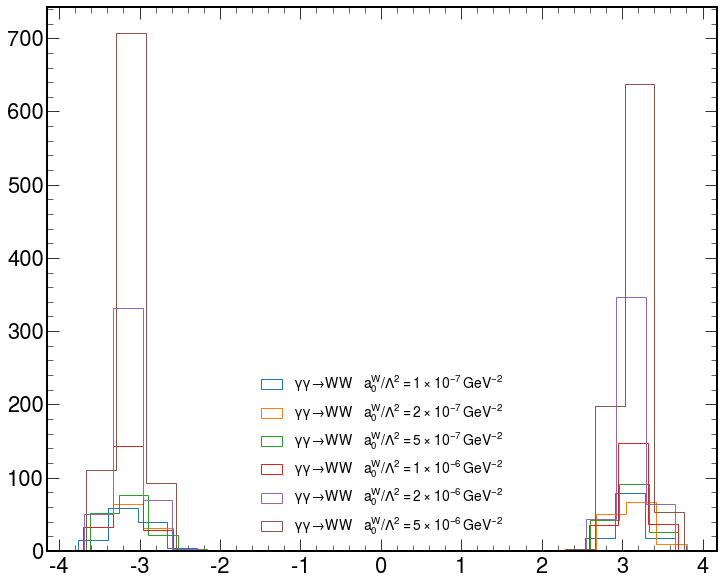

In [7]:
labels_samples = {
#     "GGToWW-AQGC-A0W5e-7": r"$\gamma\gamma \to WW \quad a_0^W/\Lambda^2 = 5 \times 10^{-7} \,\rm{GeV}^{-2}$",
    "GGToWW-AQGC-A0W1e-7": r"$\gamma\gamma \to WW \quad a_0^W/\Lambda^2 = 1 \times 10^{-7} \,\rm{GeV}^{-2}$",
    "GGToWW-AQGC-A0W2e-7": r"$\gamma\gamma \to WW \quad a_0^W/\Lambda^2 = 2 \times 10^{-7} \,\rm{GeV}^{-2}$",
    "GGToWW-AQGC-A0W5e-7": r"$\gamma\gamma \to WW \quad a_0^W/\Lambda^2 = 5 \times 10^{-7} \,\rm{GeV}^{-2}$",
    "GGToWW-AQGC-A0W1e-6": r"$\gamma\gamma \to WW \quad a_0^W/\Lambda^2 = 1 \times 10^{-6} \,\rm{GeV}^{-2}$",
    "GGToWW-AQGC-A0W2e-6": r"$\gamma\gamma \to WW \quad a_0^W/\Lambda^2 = 2 \times 10^{-6} \,\rm{GeV}^{-2}$",
    "GGToWW-AQGC-A0W5e-6": r"$\gamma\gamma \to WW \quad a_0^W/\Lambda^2 = 5 \times 10^{-6} \,\rm{GeV}^{-2}$",
    "GGToWW-AQGC-ACW5e-7": r"$\gamma\gamma \to WW \quad a_C^W/\Lambda^2 = 5 \times 10^{-7} \,\rm{GeV}^{-2}$",
    "GGToWW-AQGC-ACW1e-6": r"$\gamma\gamma \to WW \quad a_C^W/\Lambda^2 = 1 \times 10^{-6} \,\rm{GeV}^{-2}$",
    "GGToWW-AQGC-ACW2e-6": r"$\gamma\gamma \to WW \quad a_C^W/\Lambda^2 = 2 \times 10^{-6} \,\rm{GeV}^{-2}$",
    "GGToWW-AQGC-ACW5e-6": r"$\gamma\gamma \to WW \quad a_C^W/\Lambda^2 = 5 \times 10^{-6} \,\rm{GeV}^{-2}$",
    "GGToWW-AQGC-ACW1e-5": r"$\gamma\gamma \to WW \quad a_C^W/\Lambda^2 = 1 \times 10^{-5} \,\rm{GeV}^{-2}$",
    "GGToWW-AQGC-ACW2e-5": r"$\gamma\gamma \to WW \quad a_C^W/\Lambda^2 = 2 \times 10^{-5} \,\rm{GeV}^{-2}$"
}
labels_samples[ "GGToWW-AQGC-muon-A0W1e-7" ] = labels_samples[ "GGToWW-AQGC-A0W1e-7" ]
labels_samples[ "GGToWW-AQGC-muon-A0W2e-7" ] = labels_samples[ "GGToWW-AQGC-A0W2e-7" ]
labels_samples[ "GGToWW-AQGC-muon-A0W5e-7" ] = labels_samples[ "GGToWW-AQGC-A0W5e-7" ]
labels_samples[ "GGToWW-AQGC-muon-A0W1e-6" ] = labels_samples[ "GGToWW-AQGC-A0W1e-6" ]
labels_samples[ "GGToWW-AQGC-muon-A0W2e-6" ] = labels_samples[ "GGToWW-AQGC-A0W2e-6" ]
labels_samples[ "GGToWW-AQGC-muon-A0W5e-6" ] = labels_samples[ "GGToWW-AQGC-A0W5e-6" ]
labels_samples[ "GGToWW-AQGC-electron-A0W1e-7" ] = labels_samples[ "GGToWW-AQGC-A0W1e-7" ]
labels_samples[ "GGToWW-AQGC-electron-A0W2e-7" ] = labels_samples[ "GGToWW-AQGC-A0W2e-7" ]
labels_samples[ "GGToWW-AQGC-electron-A0W5e-7" ] = labels_samples[ "GGToWW-AQGC-A0W5e-7" ]
labels_samples[ "GGToWW-AQGC-electron-A0W1e-6" ] = labels_samples[ "GGToWW-AQGC-A0W1e-6" ]
labels_samples[ "GGToWW-AQGC-electron-A0W2e-6" ] = labels_samples[ "GGToWW-AQGC-A0W2e-6" ]
labels_samples[ "GGToWW-AQGC-electron-A0W5e-6" ] = labels_samples[ "GGToWW-AQGC-A0W5e-6" ]
labels_samples[ "GGToWW-AQGC-2017-muon-A0W1e-6" ] = labels_samples[ "GGToWW-AQGC-A0W1e-6" ]
labels_samples[ "GGToWW-AQGC-2017-muon-A0W2e-6" ] = labels_samples[ "GGToWW-AQGC-A0W2e-6" ]
labels_samples[ "GGToWW-AQGC-2017-muon-A0W5e-6" ] = labels_samples[ "GGToWW-AQGC-A0W5e-6" ]
labels_samples[ "GGToWW-AQGC-2017-electron-A0W1e-6" ] = labels_samples[ "GGToWW-AQGC-A0W1e-6" ]
labels_samples[ "GGToWW-AQGC-2017-electron-A0W2e-6" ] = labels_samples[ "GGToWW-AQGC-A0W2e-6" ]
labels_samples[ "GGToWW-AQGC-2017-electron-A0W5e-6" ] = labels_samples[ "GGToWW-AQGC-A0W5e-6" ]
# labels_samples[ "GGToWW-AQGC-2018-muon-A0W5e-7" ] = labels_samples[ "GGToWW-AQGC-A0W5e-7" ]
labels_samples[ "GGToWW-AQGC-2018-muon-A0W1e-7" ] = labels_samples[ "GGToWW-AQGC-A0W1e-7" ]
labels_samples[ "GGToWW-AQGC-2018-muon-A0W2e-7" ] = labels_samples[ "GGToWW-AQGC-A0W2e-7" ]
labels_samples[ "GGToWW-AQGC-2018-muon-A0W5e-7" ] = labels_samples[ "GGToWW-AQGC-A0W5e-7" ]
labels_samples[ "GGToWW-AQGC-2018-muon-A0W1e-6" ] = labels_samples[ "GGToWW-AQGC-A0W1e-6" ]
labels_samples[ "GGToWW-AQGC-2018-muon-A0W2e-6" ] = labels_samples[ "GGToWW-AQGC-A0W2e-6" ]
labels_samples[ "GGToWW-AQGC-2018-muon-A0W5e-6" ] = labels_samples[ "GGToWW-AQGC-A0W5e-6" ]
# labels_samples[ "GGToWW-AQGC-2018-electron-A0W5e-7" ] = labels_samples[ "GGToWW-AQGC-A0W5e-7" ]
labels_samples[ "GGToWW-AQGC-2018-electron-A0W1e-7" ] = labels_samples[ "GGToWW-AQGC-A0W1e-7" ]
labels_samples[ "GGToWW-AQGC-2018-electron-A0W2e-7" ] = labels_samples[ "GGToWW-AQGC-A0W2e-7" ]
labels_samples[ "GGToWW-AQGC-2018-electron-A0W5e-7" ] = labels_samples[ "GGToWW-AQGC-A0W5e-7" ]
labels_samples[ "GGToWW-AQGC-2018-electron-A0W1e-6" ] = labels_samples[ "GGToWW-AQGC-A0W1e-6" ]
labels_samples[ "GGToWW-AQGC-2018-electron-A0W2e-6" ] = labels_samples[ "GGToWW-AQGC-A0W2e-6" ]
labels_samples[ "GGToWW-AQGC-2018-electron-A0W5e-6" ] = labels_samples[ "GGToWW-AQGC-A0W5e-6" ]
labels_samples[ "GGToWW-AQGC-muon-ACW5e-7" ] = labels_samples[ "GGToWW-AQGC-ACW5e-7" ]
labels_samples[ "GGToWW-AQGC-muon-ACW1e-6" ] = labels_samples[ "GGToWW-AQGC-ACW1e-6" ]
labels_samples[ "GGToWW-AQGC-muon-ACW2e-6" ] = labels_samples[ "GGToWW-AQGC-ACW2e-6" ]
labels_samples[ "GGToWW-AQGC-muon-ACW5e-6" ] = labels_samples[ "GGToWW-AQGC-ACW5e-6" ]
labels_samples[ "GGToWW-AQGC-muon-ACW1e-5" ] = labels_samples[ "GGToWW-AQGC-ACW1e-5" ]
labels_samples[ "GGToWW-AQGC-muon-ACW2e-5" ] = labels_samples[ "GGToWW-AQGC-ACW2e-5" ]
labels_samples[ "GGToWW-AQGC-electron-ACW5e-7" ] = labels_samples[ "GGToWW-AQGC-ACW5e-7" ]
labels_samples[ "GGToWW-AQGC-electron-ACW1e-6" ] = labels_samples[ "GGToWW-AQGC-ACW1e-6" ]
labels_samples[ "GGToWW-AQGC-electron-ACW2e-6" ] = labels_samples[ "GGToWW-AQGC-ACW2e-6" ]
labels_samples[ "GGToWW-AQGC-electron-ACW5e-6" ] = labels_samples[ "GGToWW-AQGC-ACW5e-6" ]
labels_samples[ "GGToWW-AQGC-electron-ACW1e-5" ] = labels_samples[ "GGToWW-AQGC-ACW1e-5" ]
labels_samples[ "GGToWW-AQGC-electron-ACW2e-5" ] = labels_samples[ "GGToWW-AQGC-ACW2e-5" ]
labels_samples[ "GGToWW-AQGC-2017-muon-ACW5e-7" ] = labels_samples[ "GGToWW-AQGC-ACW5e-7" ]
labels_samples[ "GGToWW-AQGC-2017-muon-ACW5e-6" ] = labels_samples[ "GGToWW-AQGC-ACW5e-6" ]
labels_samples[ "GGToWW-AQGC-2017-muon-ACW2e-5" ] = labels_samples[ "GGToWW-AQGC-ACW2e-5" ]
labels_samples[ "GGToWW-AQGC-2017-electron-ACW5e-7" ] = labels_samples[ "GGToWW-AQGC-ACW5e-7" ]
labels_samples[ "GGToWW-AQGC-2017-electron-ACW5e-6" ] = labels_samples[ "GGToWW-AQGC-ACW5e-6" ]
labels_samples[ "GGToWW-AQGC-2017-electron-ACW2e-5" ] = labels_samples[ "GGToWW-AQGC-ACW2e-5" ]
labels_samples[ "GGToWW-AQGC-2018-muon-ACW5e-7" ] = labels_samples[ "GGToWW-AQGC-ACW5e-7" ]
labels_samples[ "GGToWW-AQGC-2018-muon-ACW1e-6" ] = labels_samples[ "GGToWW-AQGC-ACW1e-6" ]
labels_samples[ "GGToWW-AQGC-2018-muon-ACW2e-6" ] = labels_samples[ "GGToWW-AQGC-ACW2e-6" ]
labels_samples[ "GGToWW-AQGC-2018-muon-ACW5e-6" ] = labels_samples[ "GGToWW-AQGC-ACW5e-6" ]
labels_samples[ "GGToWW-AQGC-2018-muon-ACW1e-5" ] = labels_samples[ "GGToWW-AQGC-ACW1e-5" ]
labels_samples[ "GGToWW-AQGC-2018-muon-ACW2e-5" ] = labels_samples[ "GGToWW-AQGC-ACW2e-5" ]
labels_samples[ "GGToWW-AQGC-2018-electron-ACW5e-7" ] = labels_samples[ "GGToWW-AQGC-ACW5e-7" ]
labels_samples[ "GGToWW-AQGC-2018-electron-ACW1e-6" ] = labels_samples[ "GGToWW-AQGC-ACW1e-6" ]
labels_samples[ "GGToWW-AQGC-2018-electron-ACW2e-6" ] = labels_samples[ "GGToWW-AQGC-ACW2e-6" ]
labels_samples[ "GGToWW-AQGC-2018-electron-ACW5e-6" ] = labels_samples[ "GGToWW-AQGC-ACW5e-6" ]
labels_samples[ "GGToWW-AQGC-2018-electron-ACW1e-5" ] = labels_samples[ "GGToWW-AQGC-ACW1e-5" ]
labels_samples[ "GGToWW-AQGC-2018-electron-ACW2e-5" ] = labels_samples[ "GGToWW-AQGC-ACW2e-5" ]

if load_signal:
    fig = plt.figure( figsize=(12,10) )
    for label_ in labels_signals[:6]: 
        plt.hist( df_signals_protons_multiRP_events[ label_ ]["_nom"][ 'deltaPhi_jet_lep_nom' ], histtype='step', density=False, bins=20, label=labels_samples[ label_ ] )
    plt.legend( loc='best', fontsize=14 )

### MC (Bkg)

In [8]:
load_MC = True

labels_MC = []
if data_sample == '2017':
    if lepton_type == 'muon':
        labels_MC = [ ]
    elif lepton_type == 'electron':
        labels_MC = [ ]
elif data_sample == '2018':
    if lepton_type == 'muon':
        labels_MC = [ "Bkg-2018-muon-QCD_Pt_170to300", "Bkg-2018-muon-QCD_Pt_300to470", "Bkg-2018-muon-QCD_Pt_470to600",
                      "Bkg-2018-muon-QCD_Pt_600to800","Bkg-2018-muon-QCD_Pt_800to1000", "Bkg-2018-muon-QCD_Pt_1000to1400",
                      "Bkg-2018-muon-QCD_Pt_1400to1800", "Bkg-2018-muon-QCD_Pt_1800to2400", "Bkg-2018-muon-QCD_Pt_2400to3200", "Bkg-2018-muon-QCD_Pt_3200toInf"
                    ]
    elif lepton_type == 'electron':
        labels_MC = [ "Bkg-2018-electron-QCD_Pt_170to300", "Bkg-2018-electron-QCD_Pt_300to470", "Bkg-2018-electron-QCD_Pt_470to600",
                      "Bkg-2018-electron-QCD_Pt_600to800","Bkg-2018-electron-QCD_Pt_800to1000", "Bkg-2018-electron-QCD_Pt_1000to1400",
                      "Bkg-2018-electron-QCD_Pt_1400to1800", "Bkg-2018-electron-QCD_Pt_1800to2400", "Bkg-2018-electron-QCD_Pt_2400to3200", "Bkg-2018-electron-QCD_Pt_3200toInf"
                    ]
    
df_counts_MC = {}
df_events_MC = {}
if load_MC:
    base_path_ = "output_events"
    for label_ in labels_MC:
        print ( label_ )
        file_path_ = "{}/data-store-{}.h5".format( base_path_, label_ )
        with pd.HDFStore( file_path_, 'r' ) as store_:
            print ( list( store_ ) )
            df_counts_MC[ label_ ] = store_[ "counts" ]
            print ( df_counts_MC[ label_ ] )
            df_events_MC[ label_ ] = store_[ "events" ]

Bkg-2018-muon-QCD_Pt_170to300
['/counts', '/events']
All           1166
Jet           1166
Muon           314
check_none     314
dtype: int64
Bkg-2018-muon-QCD_Pt_300to470
['/counts', '/events']
All           5056
Jet           5056
Muon          1351
check_none    1351
dtype: int64
Bkg-2018-muon-QCD_Pt_470to600
['/counts', '/events']
All           5184
Jet           5184
Muon          1307
check_none    1307
dtype: int64
Bkg-2018-muon-QCD_Pt_600to800
['/counts', '/events']
All           7362
Jet           7362
Muon          1678
check_none    1678
dtype: int64
Bkg-2018-muon-QCD_Pt_800to1000
['/counts', '/events']
All           4398
Jet           4398
Muon          1017
check_none    1017
dtype: int64
Bkg-2018-muon-QCD_Pt_1000to1400
['/counts', '/events']
All           2561
Jet           2561
Muon           589
check_none     589
dtype: int64
Bkg-2018-muon-QCD_Pt_1400to1800
['/counts', '/events']
All           1567
Jet           1567
Muon           331
check_none     331
dtype: int64
B

In [9]:
label_ref_ = ""
if data_sample == '2017':
    if lepton_type == 'muon':
        label_ref_ = ''
    elif lepton_type == 'electron':
        label_ref_ = ''
elif data_sample == '2018':
    if lepton_type == 'muon':
        label_ref_ = 'Bkg-2018-muon-QCD_Pt_170to300'
    elif lepton_type == 'electron':
        label_ref_ = 'Bkg-2018-electron-QCD_Pt_170to300'


In [10]:
for label_ in labels_MC:
    jet0_tau21, rhoprime1, jet0_tau21_ddt = tau21_ddt_calculation(df_events_MC[ label_ ], lepton_type)
    print(jet0_tau21)
    df_events_MC[ label_ ][ "jet0_tau21" ] = jet0_tau21
    df_events_MC[ label_ ][ "jet0_tau21_nom" ] = jet0_tau21
    df_events_MC[ label_ ][ "jet0_tau21_ddt" ] = jet0_tau21_ddt
    df_events_MC[ label_ ][ "jet0_tau21_ddt_nom" ] = jet0_tau21_ddt

0      0.733404
1      0.872373
2      0.760016
3      0.529857
4      0.762305
         ...   
309    0.858261
310    0.714090
311    0.870465
312    0.765678
313    0.666147
Length: 314, dtype: float32
0       0.798083
1       0.758608
2       0.852767
3       0.880980
4       0.867796
          ...   
1346    0.943283
1347    0.829197
1348    0.833816
1349    0.726124
1350    0.770725
Length: 1351, dtype: float32
0       0.794776
1       0.807340
2       0.885080
3       0.642705
4       0.570977
          ...   
1302    0.504433
1303    0.535817
1304    0.887671
1305    0.700800
1306    0.867391
Length: 1307, dtype: float32
0       0.845270
1       0.460249
2       0.424810
3       0.892212
4       0.716070
          ...   
1673    0.575097
1674    0.876633
1675    0.791092
1676    0.818865
1677    0.796073
Length: 1678, dtype: float32
0       0.830794
1       0.610684
2       0.308675
3       0.915412
4       0.824920
          ...   
1012    0.765945
1013    0.363398
1014    0.54

In [11]:
print ( df_events_MC[ label_ref_ ].columns.values )

df_events_MC[ label_ref_ ]

['run' 'lumiblock' 'event' 'crossingAngle' 'betaStar' 'instLumi' 'jet0_pt'
 'jet0_eta' 'jet0_phi' 'jet0_energy' 'jet0_mass' 'jet0_corrmass'
 'jet0_tau1' 'jet0_tau2' 'jet0_vertexz' 'jet0_px' 'jet0_py' 'jet0_pz'
 'calo_met' 'met' 'met_x' 'met_y' 'met_phi' 'nVertices' 'num_bjets_ak8'
 'num_bjets_ak4' 'num_jets_ak4' 'pfcand_nextracks'
 'pfcand_nextracks_noDRl' 'recoMWhad' 'recoMWlep' 'recoMWlep_metJER_Up'
 'recoMWlep_metJER_Down' 'recoMWlep_metJES_Up' 'recoMWlep_metJES_Down'
 'recoMWW' 'recoMWW_metJER_Up' 'recoMWW_metJER_Down' 'recoMWW_metJES_Up'
 'recoMWW_metJES_Down' 'recoRapidityWW' 'dphiWW' 'WLeptonicPt'
 'WLeptonicPt_metJER_Up' 'WLeptonicPt_metJER_Down' 'WLeptonicPt_metJES_Up'
 'WLeptonicPt_metJES_Down' 'WLeptonicEta' 'WLeptonicPhi' 'muon0_pt'
 'muon0_eta' 'muon0_phi' 'muon0_energy' 'muon0_charge' 'muon0_iso'
 'muon0_dxy' 'muon0_dz' 'muon0_trackerLayersWithMeasurement'
 'muon0_Roccor' 'muon0_deltaRoccor' 'run_mc' 'pileupWeight'
 'mc_pu_trueinteractions' 'mcWeight' 'prefiring_weight'
 

,run,lumiblock,event,crossingAngle,betaStar,instLumi,jet0_pt,jet0_eta,jet0_phi,jet0_energy,...,xiCMS_45_jes_dw,xiCMS_56_jes_dw,xiCMS_45_jer_up,xiCMS_56_jer_up,xiCMS_45_jer_dw,xiCMS_56_jer_dw,jet0_tau21,jet0_tau21_nom,jet0_tau21_ddt,jet0_tau21_ddt_nom
0,1,621,620452,152.0,0.4,0.0,200.880112,1.667969,1.318036,552.575684,...,0.096580,0.007751,0.098415,0.007816,0.098470,0.007818,0.733404,0.733404,0.587694,0.587694
1,1,6526,6525807,152.0,0.4,0.0,340.317810,-0.205383,-2.725613,351.304535,...,0.027876,0.102572,0.028014,0.102780,0.027983,0.102733,0.872373,0.872373,0.832834,0.832834
2,1,8835,8834837,152.0,0.4,0.0,274.898773,-0.321142,-3.030490,302.098450,...,0.031731,0.042245,0.031851,0.042474,0.031806,0.042387,0.760016,0.760016,0.939298,0.939298
3,1,12351,12350565,152.0,0.4,0.0,256.628784,0.105954,3.108154,267.300537,...,0.029909,0.021901,0.030082,0.022040,0.030024,0.021993,0.529857,0.529857,0.677833,0.677833
4,1,22637,22636878,152.0,0.4,0.0,255.693069,1.179222,1.048896,459.304443,...,0.070900,0.031817,0.071767,0.031899,0.071167,0.031842,0.762305,0.762305,0.902520,0.902520
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
309,1,28463,28462530,152.0,0.4,0.0,268.539978,1.106296,-2.746235,453.615204,...,0.081585,0.009264,0.082162,0.009327,0.082080,0.009318,0.858261,0.858261,0.778317,0.778317
310,1,28249,28248380,152.0,0.4,0.0,355.633179,0.326534,1.549564,379.963013,...,0.063512,0.029527,0.063754,0.029653,0.063698,0.029624,0.714090,0.714090,0.650215,0.650215
311,1,29406,29405170,152.0,0.4,0.0,224.438965,1.344250,-2.539679,462.376495,...,0.121735,0.007674,0.117246,0.007369,0.121486,0.007657,0.870465,0.870465,0.885841,0.885841
312,1,29767,29766814,152.0,0.4,0.0,209.223755,1.462733,-0.447006,478.947021,...,0.079372,0.017467,0.080934,0.017550,0.080809,0.017544,0.765678,0.765678,0.671343,0.671343


In [12]:
df_events_MC

{'Bkg-2018-muon-QCD_Pt_170to300':      run  lumiblock     event  crossingAngle  betaStar  instLumi     jet0_pt  \
 0      1        621    620452          152.0       0.4       0.0  200.880112   
 1      1       6526   6525807          152.0       0.4       0.0  340.317810   
 2      1       8835   8834837          152.0       0.4       0.0  274.898773   
 3      1      12351  12350565          152.0       0.4       0.0  256.628784   
 4      1      22637  22636878          152.0       0.4       0.0  255.693069   
 ..   ...        ...       ...            ...       ...       ...         ...   
 309    1      28463  28462530          152.0       0.4       0.0  268.539978   
 310    1      28249  28248380          152.0       0.4       0.0  355.633179   
 311    1      29406  29405170          152.0       0.4       0.0  224.438965   
 312    1      29767  29766814          152.0       0.4       0.0  209.223755   
 313    1      29976  29975312          156.0       0.4       0.0  205.93489

In [13]:
labels_samples = {
    "Bkg-2018-muon-QCD_Pt_170to300": r"QCD $170$--$300\,\rm{GeV}$",
    "Bkg-2018-electron-QCD_Pt_170to300": r"QCD $170$--$300\,\rm{GeV}$",
    "Bkg-2018-muon-QCD_Pt_300to470": r"QCD $300$--$470\,\rm{GeV}$",
    "Bkg-2018-electron-QCD_Pt_300to470": r"QCD $300$--$470\,\rm{GeV}$",
    "Bkg-2018-muon-QCD_Pt_470to600": r"QCD $470$--$600\,\rm{GeV}$",
    "Bkg-2018-electron-QCD_Pt_470to600": r"QCD $470$--$600\,\rm{GeV}$",
    "Bkg-2018-muon-QCD_Pt_600to800": r"QCD $600$--$800\,\rm{GeV}$",
    "Bkg-2018-electron-QCD_Pt_600to800": r"QCD $600$--$800\,\rm{GeV}$",
    "Bkg-2018-muon-QCD_Pt_800to1000": r"QCD $800$--$1000\,\rm{GeV}$",
    "Bkg-2018-electron-QCD_Pt_800to1000": r"QCD $800$--$1000\,\rm{GeV}$",
    "Bkg-2018-muon-QCD_Pt_1000to1400": r"QCD $1000$--$1400\,\rm{GeV}$",
    "Bkg-2018-electron-QCD_Pt_1000to1400": r"QCD $1000$--$1400\,\rm{GeV}$",
    "Bkg-2018-muon-QCD_Pt_1400to1800": r"QCD $1400$--$1800\,\rm{GeV}$",
    "Bkg-2018-electron-QCD_Pt_1400to1800": r"QCD $1400$--$1800\,\rm{GeV}$",
    "Bkg-2018-muon-QCD_Pt_1800to2400": r"QCD $1800$--$2400\,\rm{GeV}$",
    "Bkg-2018-electron-QCD_Pt_1800to2400": r"QCD $1800$--$2400\,\rm{GeV}$",
    "Bkg-2018-muon-QCD_Pt_2400to3200": r"QCD $2400$--$3200\,\rm{GeV}$",
    "Bkg-2018-electron-QCD_Pt_2400to3200": r"QCD $2400$--$3200\,\rm{GeV}$",
    "Bkg-2018-muon-QCD_Pt_3200toInf": r"QCD $3200$--$\,\rm{GeV}$",
    "Bkg-2018-electron-QCD_Pt_3200toInf": r"QCD $3200$--$\,\rm{GeV}$",
    "Bkg-2018-muon-QCD": r"QCD",
    "Bkg-2018-electron-QCD": r"QCD"
}

In [14]:
##var__ = "jet0_pt_nom"
##if load_MC:
##    fig = plt.figure( figsize=(12,10) )
##    for label__ in labels_MC: 
##        plt.hist( df_events_MC[ label__ ][ var__ ], histtype='step', density=False, bins=50, label=labels_samples[ label__ ] )
##    plt.legend( loc='best', fontsize=14 )

### Select events

In [15]:
df_selected_events_MC = {}

variations_ = { "jet": [ "_jes_up", "_jes_dw", "_jer_up", "_jer_dw" ] }
for label__ in labels_MC:
    print ( label__ )
    df_events__ = df_events_MC[ label__ ]
    print ( df_events__.shape[0] )
    df_selected_events__, selection_keys__, selections__, deltaR_jet_lep_  = select_events( df_events__, lepton_type )
    print ( df_selected_events__.shape[0] )
    print ( selection_keys__ )
    print ( selections__ )
    df_selected_events_MC[ label__ ] = {}
    df_selected_events_MC[ label__ ][ "_nom" ] = df_selected_events__
    for var_label__ in variations_:
        print ( var_label__ )
        for variation__ in variations_[ var_label__ ]:
            opt__ = { "label_" + var_label__ : variation__ }
            print ( opt__ )
            df_selected_events__, selection_keys__, selections__, deltaR_jet_lep_  = select_events( df_events__, lepton_type, **opt__ )
            print ( df_selected_events__.shape[0] )
            print ( selection_keys__ )
            print ( selections__ )
            df_selected_events_MC[ label__ ][ variation__ ] = df_selected_events__

Bkg-2018-muon-QCD_Pt_170to300
314
15
['All', 'Muon', 'Jet', 'Jet_Muon', 'MET', 'Jet_MET', 'PrunedMass', 'BJet_Veto', 'Xi_CMS', 'WLeptonic', 'Jet_WLeptonic', 'MWW', 'ExtraTracks']
{'All': 314, 'Muon': 312, 'Jet': 215, 'Jet_Muon': 214, 'MET': 159, 'Jet_MET': 150, 'PrunedMass': 28, 'BJet_Veto': 25, 'Xi_CMS': 23, 'WLeptonic': 16, 'Jet_WLeptonic': 15, 'MWW': 15, 'ExtraTracks': 15}
jet
{'label_jet': '_jes_up'}
16
['All', 'Muon', 'Jet', 'Jet_Muon', 'MET', 'Jet_MET', 'PrunedMass', 'BJet_Veto', 'Xi_CMS', 'WLeptonic', 'Jet_WLeptonic', 'MWW', 'ExtraTracks']
{'All': 314, 'Muon': 312, 'Jet': 230, 'Jet_Muon': 229, 'MET': 169, 'Jet_MET': 160, 'PrunedMass': 30, 'BJet_Veto': 27, 'Xi_CMS': 25, 'WLeptonic': 17, 'Jet_WLeptonic': 16, 'MWW': 16, 'ExtraTracks': 16}
{'label_jet': '_jes_dw'}
15
['All', 'Muon', 'Jet', 'Jet_Muon', 'MET', 'Jet_MET', 'PrunedMass', 'BJet_Veto', 'Xi_CMS', 'WLeptonic', 'Jet_WLeptonic', 'MWW', 'ExtraTracks']
{'All': 314, 'Muon': 312, 'Jet': 207, 'Jet_Muon': 206, 'MET': 152, 'Jet_MET':

50
['All', 'Muon', 'Jet', 'Jet_Muon', 'MET', 'Jet_MET', 'PrunedMass', 'BJet_Veto', 'Xi_CMS', 'WLeptonic', 'Jet_WLeptonic', 'MWW', 'ExtraTracks']
{'All': 1017, 'Muon': 1015, 'Jet': 1015, 'Jet_Muon': 1015, 'MET': 901, 'Jet_MET': 791, 'PrunedMass': 117, 'BJet_Veto': 107, 'Xi_CMS': 51, 'WLeptonic': 50, 'Jet_WLeptonic': 50, 'MWW': 50, 'ExtraTracks': 50}
{'label_jet': '_jer_up'}
48
['All', 'Muon', 'Jet', 'Jet_Muon', 'MET', 'Jet_MET', 'PrunedMass', 'BJet_Veto', 'Xi_CMS', 'WLeptonic', 'Jet_WLeptonic', 'MWW', 'ExtraTracks']
{'All': 1017, 'Muon': 1015, 'Jet': 1014, 'Jet_Muon': 1014, 'MET': 900, 'Jet_MET': 790, 'PrunedMass': 117, 'BJet_Veto': 106, 'Xi_CMS': 49, 'WLeptonic': 48, 'Jet_WLeptonic': 48, 'MWW': 48, 'ExtraTracks': 48}
{'label_jet': '_jer_dw'}
49
['All', 'Muon', 'Jet', 'Jet_Muon', 'MET', 'Jet_MET', 'PrunedMass', 'BJet_Veto', 'Xi_CMS', 'WLeptonic', 'Jet_WLeptonic', 'MWW', 'ExtraTracks']
{'All': 1017, 'Muon': 1015, 'Jet': 1015, 'Jet_Muon': 1015, 'MET': 901, 'Jet_MET': 791, 'PrunedMass': 11

In [16]:
df_selected_events_MC

{'Bkg-2018-muon-QCD_Pt_170to300': {'_nom':      run  lumiblock     event  crossingAngle  betaStar  instLumi     jet0_pt  \
  46     1      23229  23228708          152.0       0.4       0.0  252.069702   
  83     1      10364  10363608          152.0       0.4       0.0  257.210327   
  141    1      26787  26786616          156.0       0.4       0.0  285.719849   
  183    1       2946   2945753          152.0       0.4       0.0  269.349609   
  210    1      20247  20246364          156.0       0.4       0.0  274.015015   
  211    1      12032  12031764          152.0       0.4       0.0  230.114868   
  238    1      15670  15669199          152.0       0.4       0.0  220.935806   
  240    1      15534  15533349          152.0       0.4       0.0  233.309769   
  250    1      20949  20948686          153.0       0.4       0.0  261.418213   
  251    1      17917  17916672          152.0       0.4       0.0  311.645966   
  255    1      18868  18867216          156.0       0.4 

In [17]:
import json
samples_info = None
if data_sample == '2017':
    pass
elif data_sample == '2018':
    samples_info = json.load( open( 'samples_info_UL18_XSDB.json' ) )
samples_info

{'FPMC_WW_bSM_13tev_a0w_1e-7_aCw_0_semi_pt0': [130939.0, 0.040469115, 1.0, 6],
 'FPMC_WW_bSM_13tev_a0w_2e-7_aCw_0_semi_pt0': [131183.0, 0.040615825, 1.0, 6],
 'FPMC_WW_bSM_13tev_a0w_5e-7_aCw_0_semi_pt0': [131046.0, 0.041579465, 1.0, 6],
 'FPMC_WW_bSM_13tev_a0w_1e-6_aCw_0_semi_pt0': [130973.0, 0.044930565, 1.0, 6],
 'FPMC_WW_bSM_13tev_a0w_2e-6_aCw_0_semi_pt0': [131203.0, 0.058176638, 1.0, 6],
 'FPMC_WW_bSM_13tev_a0w_5e-6_aCw_0_semi_pt0': [131351.0, 0.15026584, 1.0, 6],
 'FPMC_WW_bSM_13tev_a0w_0_aCw_5e-7_semi_pt0': [131205.0, 0.040550411, 1.0, 6],
 'FPMC_WW_bSM_13tev_a0w_0_aCw_1e-6_semi_pt0': [131474.0, 0.040845135, 1.0, 6],
 'FPMC_WW_bSM_13tev_a0w_0_aCw_2e-6_semi_pt0': [131467.0, 0.041896497, 1.0, 6],
 'FPMC_WW_bSM_13tev_a0w_0_aCw_5e-6_semi_pt0': [131370.0, 0.048745879, 1.0, 6],
 'FPMC_WW_bSM_13tev_a0w_0_aCw_1e-5_semi_pt0': [131582.0, 0.072479178, 1.0, 6],
 'FPMC_WW_bSM_13tev_a0w_0_aCw_2e-5_semi_pt0': [131524.0, 0.16613701, 1.0, 6],
 'FPMC_WW_bSM_13tev_a0w_0_aCw_0_semi_pt0': [262999.0, 

In [18]:
sample_names = {}
if data_sample == '2017':
    pass
elif data_sample == '2018':
    sample_names[ "Bkg-2018-muon-QCD_Pt_170to300" ] = 'QCD_Pt_170to300_TuneCP5_13TeV-pythia8'
    sample_names[ "Bkg-2018-muon-QCD_Pt_300to470" ] = 'QCD_Pt_300to470_TuneCP5_13TeV-pythia8'
    sample_names[ "Bkg-2018-muon-QCD_Pt_470to600" ] = 'QCD_Pt_470to600_TuneCP5_13TeV-pythia8'
    sample_names[ "Bkg-2018-muon-QCD_Pt_600to800" ] = 'QCD_Pt_600to800_TuneCP5_13TeV-pythia8'
    sample_names[ "Bkg-2018-muon-QCD_Pt_800to1000" ] = 'QCD_Pt_800to1000_TuneCP5_13TeV-pythia8'
    sample_names[ "Bkg-2018-muon-QCD_Pt_1000to1400" ] = 'QCD_Pt_1000to1400_TuneCP5_13TeV-pythia8'
    sample_names[ "Bkg-2018-muon-QCD_Pt_1400to1800" ] = 'QCD_Pt_1400to1800_TuneCP5_13TeV-pythia8'
    sample_names[ "Bkg-2018-muon-QCD_Pt_1800to2400" ] = 'QCD_Pt_1800to2400_TuneCP5_13TeV-pythia8'
    sample_names[ "Bkg-2018-muon-QCD_Pt_2400to3200" ] = 'QCD_Pt_2400to3200_TuneCP5_13TeV-pythia8'
    sample_names[ "Bkg-2018-muon-QCD_Pt_3200toInf" ] = 'QCD_Pt_3200toInf_TuneCP5_13TeV-pythia8'
    sample_names[ "Bkg-2018-electron-QCD_Pt_170to300" ] = 'QCD_Pt_170to300_TuneCP5_13TeV-pythia8'
    sample_names[ "Bkg-2018-electron-QCD_Pt_300to470" ] = 'QCD_Pt_300to470_TuneCP5_13TeV-pythia8'
    sample_names[ "Bkg-2018-electron-QCD_Pt_470to600" ] = 'QCD_Pt_470to600_TuneCP5_13TeV-pythia8'
    sample_names[ "Bkg-2018-electron-QCD_Pt_600to800" ] = 'QCD_Pt_600to800_TuneCP5_13TeV-pythia8'
    sample_names[ "Bkg-2018-electron-QCD_Pt_800to1000" ] = 'QCD_Pt_800to1000_TuneCP5_13TeV-pythia8'
    sample_names[ "Bkg-2018-electron-QCD_Pt_1000to1400" ] = 'QCD_Pt_1000to1400_TuneCP5_13TeV-pythia8'
    sample_names[ "Bkg-2018-electron-QCD_Pt_1400to1800" ] = 'QCD_Pt_1400to1800_TuneCP5_13TeV-pythia8'
    sample_names[ "Bkg-2018-electron-QCD_Pt_1800to2400" ] = 'QCD_Pt_1800to2400_TuneCP5_13TeV-pythia8'
    sample_names[ "Bkg-2018-electron-QCD_Pt_2400to3200" ] = 'QCD_Pt_2400to3200_TuneCP5_13TeV-pythia8'
    sample_names[ "Bkg-2018-electron-QCD_Pt_3200toInf" ] = 'QCD_Pt_3200toInf_TuneCP5_13TeV-pythia8'


In [19]:
lumi_periods = None
if data_sample == '2017':
    if lepton_type == 'muon':
        lumi_periods = lumi_periods_2017[ 'muon' ]
    elif lepton_type == 'electron':
        lumi_periods = lumi_periods_2017[ 'electron' ]
elif data_sample == '2018':
    if lepton_type == 'muon':
        lumi_periods = lumi_periods_2018[ 'muon' ]
    elif lepton_type == 'electron':
        lumi_periods = lumi_periods_2018[ 'electron' ]
    
lumi = np.sum( list( lumi_periods.values() ) )
print ( lumi )
    
norm_factors = {}
for label__ in labels_MC:
    print ( label__ )
    print ( samples_info[ sample_names[ label__ ] ] )
    sample_nevents_, sample_cross_section_, sel_eff_, _ = samples_info[ sample_names[ label__ ] ]
    sample_cross_section_ = sample_cross_section_ * sel_eff_
#     if norm_to_1fb:
#         sample_cross_section_ = 1.e-03
    print ( sample_cross_section_ )
    norm_factors[ label__ ] = np.array( [ lumi / ( sample_nevents_ ), sample_cross_section_*1000, 1.0 ] )
    print ( norm_factors[ label__ ] )
    norm_factors_product_ = np.product( norm_factors[ label__ ] )
    print ( norm_factors_product_ )
    if df_selected_events_MC[ label__ ][ "_nom" ].shape[0] > 0:
        df_selected_events_MC[ label__ ][ "_nom" ].loc[ :, "norm" ] = norm_factors_product_
    for variation__ in df_selected_events_MC[ label__ ]:
        print ( variation__ )
        if df_selected_events_MC[ label__ ][ variation__ ].shape[0] > 0:
            df_selected_events_MC[ label__ ][ variation__ ].loc[ :, "norm" ] = norm_factors_product_

55.700985822999996
Bkg-2018-muon-QCD_Pt_170to300
[29676000.0, 103700, 1.0, 800]
103700.0
[1.87697081e-06 1.03700000e+08 1.00000000e+00]
194.64187322567392
_nom
_jes_up
_jes_dw
_jer_up
_jer_dw
Bkg-2018-muon-QCD_Pt_300to470
[57910000.0, 6830, 1.0, 800]
6830.0
[9.61854357e-07 6.83000000e+06 1.00000000e+00]
6.569465259386807
_nom
_jes_up
_jes_dw
_jer_up
_jer_dw
Bkg-2018-muon-QCD_Pt_470to600
[52448000.0, 551.2, 1.0, 800]
551.2
[1.06202307e-06 5.51200000e+05 1.00000000e+00]
0.5853871145827791
_nom
_jes_up
_jes_dw
_jer_up
_jer_dw
Bkg-2018-muon-QCD_Pt_600to800
[67508000.0, 156.7, 1.0, 800]
156.7
[8.25102e-07 1.56700e+05 1.00000e+00]
0.12929348341624844
_nom
_jes_up
_jes_dw
_jer_up
_jer_dw
Bkg-2018-muon-QCD_Pt_800to1000
[37160000.0, 26.25, 1.0, 800]
26.25
[1.4989501e-06 2.6250000e+04 1.0000000e+00]
0.0393474402005853
_nom
_jes_up
_jes_dw
_jer_up
_jer_dw
Bkg-2018-muon-QCD_Pt_1000to1400
[19730000.0, 7.465, 1.0, 800]
7.465
[2.82316198e-06 7.46500000e+03 1.00000000e+00]
0.021074904164657626
_nom
_j

/tmp/ipykernel_3137/3912546779.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_selected_events_MC[ label__ ][ "_nom" ].loc[ :, "norm" ] = norm_factors_product_
/tmp/ipykernel_3137/3912546779.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_selected_events_MC[ label__ ][ variation__ ].loc[ :, "norm" ] = norm_factors_product_
/tmp/ipykernel_3137/3912546779.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] =

In [20]:
var_name__ = ""
if lepton_type == 'muon':
    var_name__ = "sf_muon_id"
elif lepton_type == 'electron':
    var_name__ = "sf_electron_id"
var_name_up__ = var_name__ + "_up"
var_name_dw__ = var_name__ + "_dw"

df_selected_events_MC[ "Bkg-2018-"+lepton_type+"-QCD_Pt_170to300" ][ "_nom" ][ [ var_name__, var_name_up__, var_name_dw__ ] ]

,sf_muon_id,sf_muon_id_up,sf_muon_id_dw
46,0.989417,0.995193,0.983642
83,0.996643,0.997023,0.996263
141,0.995787,0.996356,0.995218
183,0.996643,0.997023,0.996263
210,0.996643,0.997023,0.996263
211,0.996643,0.997023,0.996263
238,0.996643,0.997023,0.996263
240,0.996095,0.996925,0.995265
250,0.996643,0.997023,0.996263
251,0.995787,0.996356,0.995218


In [21]:
df_selected_events_MC[ "Bkg-2018-"+lepton_type+"-QCD_Pt_170to300" ][ "_nom" ][ [ "pileupWeight" ] ]

,pileupWeight
46,1.016032
83,1.011660
141,1.020879
183,1.003386
210,1.037180
211,0.990842
238,0.946417
240,0.918710
250,0.998228
251,1.047111


In [22]:
label_WJetsToLNu = ''
samples_WJetsToLNu = []
label_DYJetsToLL = ''
samples_DYJetsToLL = []
label_QCD = ''
samples_QCD = []
label_ST = ''
samples_ST = []
label_VV = ''
samples_VV = []
if data_sample == '2017':
    if lepton_type == 'muon':
        label_WJetsToLNu = ''
        samples_WJetsToLNu = [ ]
        label_DYJetsToLL = ''
        samples_DYJetsToLL = []
        label_QCD = ''
        samples_QCD = []
        label_ST = ''
        samples_ST = []
        label_VV = ''
        samples_VV = []
    elif lepton_type == 'electron':
        label_WJetsToLNu = ''
        samples_WJetsToLNu = [ ]
        label_DYJetsToLL = ''
        samples_DYJetsToLL = []
        label_QCD = ''
        samples_QCD = []
        label_ST = ''
        samples_ST = []
        label_VV = ''
        samples_VV = []
elif data_sample == '2018':
    if lepton_type == 'muon':
        label_QCD = "Bkg-2018-muon-QCD"
        samples_QCD = [ "Bkg-2018-muon-QCD_Pt_170to300", "Bkg-2018-muon-QCD_Pt_300to470", "Bkg-2018-muon-QCD_Pt_470to600",
                        "Bkg-2018-muon-QCD_Pt_600to800","Bkg-2018-muon-QCD_Pt_800to1000", "Bkg-2018-muon-QCD_Pt_1000to1400",
                        "Bkg-2018-muon-QCD_Pt_1400to1800", "Bkg-2018-muon-QCD_Pt_1800to2400", "Bkg-2018-muon-QCD_Pt_2400to3200", "Bkg-2018-muon-QCD_Pt_3200toInf" ]
    elif lepton_type == 'electron':
        label_QCD = "Bkg-2018-electron-QCD"
        samples_QCD = [ "Bkg-2018-electron-QCD_Pt_170to300", "Bkg-2018-electron-QCD_Pt_300to470", "Bkg-2018-electron-QCD_Pt_470to600",
                        "Bkg-2018-electron-QCD_Pt_600to800","Bkg-2018-electron-QCD_Pt_800to1000", "Bkg-2018-electron-QCD_Pt_1000to1400",
                        "Bkg-2018-electron-QCD_Pt_1400to1800", "Bkg-2018-electron-QCD_Pt_1800to2400", "Bkg-2018-electron-QCD_Pt_2400to3200", "Bkg-2018-electron-QCD_Pt_3200toInf" ]

df_selected_events_MC[ label_QCD ] = {}

for variation__ in df_selected_events_MC[ samples_QCD[ 0 ] ]:
    print ( variation__ )
    df_events_list__ = []
    for label__ in samples_QCD:
        df_events_list__.append( df_selected_events_MC[ label__ ][ variation__ ] )
    df_selected_events_MC[ label_QCD ][ variation__ ] = pd.concat( df_events_list__ )

labels_MC.append( label_QCD )

_nom
_jes_up
_jes_dw
_jer_up
_jer_dw


In [23]:
df_selected_events_MC[ label_QCD ]

{'_nom':      run  lumiblock     event  crossingAngle  betaStar  instLumi      jet0_pt  \
 46     1      23229  23228708          152.0       0.4       0.0   252.069702   
 83     1      10364  10363608          152.0       0.4       0.0   257.210327   
 141    1      26787  26786616          156.0       0.4       0.0   285.719849   
 183    1       2946   2945753          152.0       0.4       0.0   269.349609   
 210    1      20247  20246364          156.0       0.4       0.0   274.015015   
 ..   ...        ...       ...            ...       ...       ...          ...   
 416    1       2369   2368237          152.0       0.4       0.0   928.553833   
 429    1       6577   6576900          152.0       0.4       0.0  1167.119507   
 453    1       4930   4929412          152.0       0.4       0.0  1016.702881   
 463    1       5064   5063819          152.0       0.4       0.0   596.925781   
 208    1       8737   8736495          152.0       0.4       0.0   809.631592   
 
      

In [24]:
jet0_tau21_QCD, rhoprime1_QCD, jet0_tau21_ddt_QCD = tau21_ddt_calculation(df_selected_events_MC[ label_QCD ][ "_nom" ], lepton_type)
print(jet0_tau21_QCD)
print(rhoprime1_QCD)
print(jet0_tau21_ddt_QCD)

46     0.561202
83     0.607990
141    0.662648
183    0.599341
210    0.548327
         ...   
416    0.501067
429    0.617212
453    0.796942
463    0.443261
208    0.570950
Length: 364, dtype: float32
46     3.332735
83     3.365410
141    2.892566
183    2.564986
210    2.379697
         ...   
416    2.478035
429    1.453844
453    1.736870
463    2.342093
208    1.275757
Length: 364, dtype: float32
46     0.794013
83     0.843083
141    0.864711
183    0.778520
210    0.714563
         ...   
416    0.674173
429    0.718772
453    0.918272
463    0.606870
208    0.660069
Length: 364, dtype: float32


In [25]:
variations_weights_ = [ "nom" ]

if lepton_type == 'muon':
    variations_weights_sf_muon_id_ = [ "sf_muon_id_up", "sf_muon_id_dw" ]
    variations_weights_.extend( variations_weights_sf_muon_id_ )
    variations_weights_sf_muon_trigger_ = [ "sf_muon_trigger_up", "sf_muon_trigger_dw" ]
    variations_weights_.extend( variations_weights_sf_muon_trigger_ )
elif lepton_type == 'electron':
    variations_weights_sf_electron_id_ = [ "sf_electron_id_up", "sf_electron_id_dw" ]
    variations_weights_.extend( variations_weights_sf_electron_id_ )
    variations_weights_sf_electron_trigger_ = [ "sf_electron_trigger_up", "sf_electron_trigger_dw" ]
    variations_weights_.extend( variations_weights_sf_electron_trigger_ )

variations_weights_sf_prefiring_ = [ "sf_prefiring_up", "sf_prefiring_dw" ]
variations_weights_.extend( variations_weights_sf_prefiring_ )    
    
var_names_sf_lepton_id__ = {}
if lepton_type == 'muon':
    for key_ in [ "nom",
                  "sf_prefiring_up", "sf_prefiring_dw",
                  "sf_muon_trigger_up", "sf_muon_trigger_dw" ]: var_names_sf_lepton_id__[ key_ ] = "sf_muon_id"
    var_names_sf_lepton_id__[ "sf_muon_id_up" ] = "sf_muon_id_up"
    var_names_sf_lepton_id__[ "sf_muon_id_dw" ] = "sf_muon_id_dw"
elif lepton_type == 'electron':
    for key_ in [ "nom",
                  "sf_prefiring_up", "sf_prefiring_dw",
                  "sf_electron_trigger_up", "sf_electron_trigger_dw" ]: var_names_sf_lepton_id__[ key_ ] = "sf_electron_id"
    var_names_sf_lepton_id__[ "sf_electron_id_up" ] = "sf_electron_id_up"
    var_names_sf_lepton_id__[ "sf_electron_id_dw" ] = "sf_electron_id_dw"
    
var_names_sf_trigger__ = {}
if lepton_type == 'muon':
    for key_ in [ "nom",
                  "sf_prefiring_up", "sf_prefiring_dw",
                  "sf_muon_id_up", "sf_muon_id_dw" ]:
        var_names_sf_trigger__[ key_ ] = "sf_muon_trigger"
    var_names_sf_trigger__[ "sf_muon_trigger_up" ] = "sf_muon_trigger_up"
    var_names_sf_trigger__[ "sf_muon_trigger_dw" ] = "sf_muon_trigger_dw"
elif lepton_type == 'electron':
    for key_ in [ "nom",
                  "sf_prefiring_up", "sf_prefiring_dw",
                  "sf_electron_id_up", "sf_electron_id_dw" ]:
        var_names_sf_trigger__[ key_ ] = "sf_electron_trigger"
    var_names_sf_trigger__[ "sf_electron_trigger_up" ] = "sf_electron_trigger_up"
    var_names_sf_trigger__[ "sf_electron_trigger_dw" ] = "sf_electron_trigger_dw"

var_names_sf_prefiring__ = {}
if lepton_type == 'muon':
    for key_ in [ "nom",
                  "sf_muon_id_up", "sf_muon_id_dw",
                  "sf_muon_trigger_up", "sf_muon_trigger_dw" ]:
        var_names_sf_prefiring__[ key_ ] = "prefiring_weight"
elif lepton_type == 'electron':
    for key_ in [ "nom",
                  "sf_electron_id_up", "sf_electron_id_dw",
                  "sf_electron_trigger_up", "sf_electron_trigger_dw" ]:
        var_names_sf_prefiring__[ key_ ] = "prefiring_weight"
var_names_sf_prefiring__[ "sf_prefiring_up" ] = "prefiring_weight_up"
var_names_sf_prefiring__[ "sf_prefiring_dw" ] = "prefiring_weight_down"
    
print ( variations_weights_ )
print ( var_names_sf_lepton_id__ )
print ( var_names_sf_trigger__ )
print ( var_names_sf_prefiring__ )

weights_events_MC = {}
for label__ in labels_MC:
    print ( label__ )
    
    weights_events_MC[ label__ ] = {}
    for var_weights__ in variations_weights_:
        weights_events_MC[ label__ ][ var_weights__ ] = {}
        for variation__ in df_selected_events_MC[ label__ ]:
            df_selected_events__ = df_selected_events_MC[ label__ ][ variation__ ]
            if df_selected_events__.shape[0] > 0:
                weights_events_MC[ label__ ][ var_weights__ ][ variation__ ] = ( df_selected_events__[ "norm" ] * 
                                                                                 df_selected_events__[ "pileupWeight" ] *
                                                                                 df_selected_events__[ var_names_sf_lepton_id__[ var_weights__ ] ] *
                                                                                 df_selected_events__[ var_names_sf_trigger__[ var_weights__ ] ] *
                                                                                 df_selected_events__[ var_names_sf_prefiring__[ var_weights__ ] ] )

print ( weights_events_MC )

['nom', 'sf_muon_id_up', 'sf_muon_id_dw', 'sf_muon_trigger_up', 'sf_muon_trigger_dw', 'sf_prefiring_up', 'sf_prefiring_dw']
{'nom': 'sf_muon_id', 'sf_prefiring_up': 'sf_muon_id', 'sf_prefiring_dw': 'sf_muon_id', 'sf_muon_trigger_up': 'sf_muon_id', 'sf_muon_trigger_dw': 'sf_muon_id', 'sf_muon_id_up': 'sf_muon_id_up', 'sf_muon_id_dw': 'sf_muon_id_dw'}
{'nom': 'sf_muon_trigger', 'sf_prefiring_up': 'sf_muon_trigger', 'sf_prefiring_dw': 'sf_muon_trigger', 'sf_muon_id_up': 'sf_muon_trigger', 'sf_muon_id_dw': 'sf_muon_trigger', 'sf_muon_trigger_up': 'sf_muon_trigger_up', 'sf_muon_trigger_dw': 'sf_muon_trigger_dw'}
{'nom': 'prefiring_weight', 'sf_muon_id_up': 'prefiring_weight', 'sf_muon_id_dw': 'prefiring_weight', 'sf_muon_trigger_up': 'prefiring_weight', 'sf_muon_trigger_dw': 'prefiring_weight', 'sf_prefiring_up': 'prefiring_weight_up', 'sf_prefiring_dw': 'prefiring_weight_down'}
Bkg-2018-muon-QCD_Pt_170to300
Bkg-2018-muon-QCD_Pt_300to470
Bkg-2018-muon-QCD_Pt_470to600
Bkg-2018-muon-QCD_Pt_60

### Plot MC

BinnedStatisticResult(statistic=array([[ 0.        ,  0.74651378, 10.45081434, 47.58105567, 51.48410693,
        60.40081818, 28.37433033,  4.54553461,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        

/tmp/ipykernel_3137/2051210723.py:17: RuntimeWarning: invalid value encountered in divide
  mean_y_binned  = ( sum_y_binned / count_y_binned )
/tmp/ipykernel_3137/2051210723.py:18: RuntimeWarning: invalid value encountered in divide
  mean_y2_binned = ( sum_y2_binned / count_y_binned )
/tmp/ipykernel_3137/2051210723.py:19: RuntimeWarning: invalid value encountered in sqrt
  stddev_binned  = np.sqrt( mean_y2_binned - mean_y_binned ** 2 )
/tmp/ipykernel_3137/2051210723.py:20: RuntimeWarning: invalid value encountered in sqrt
  stddev_binned_ddof1 = stddev_binned * np.sqrt( count_y_binned ) / np.sqrt( count_y_binned - 1 )


-0.06985584011450555
0.7297606700952494


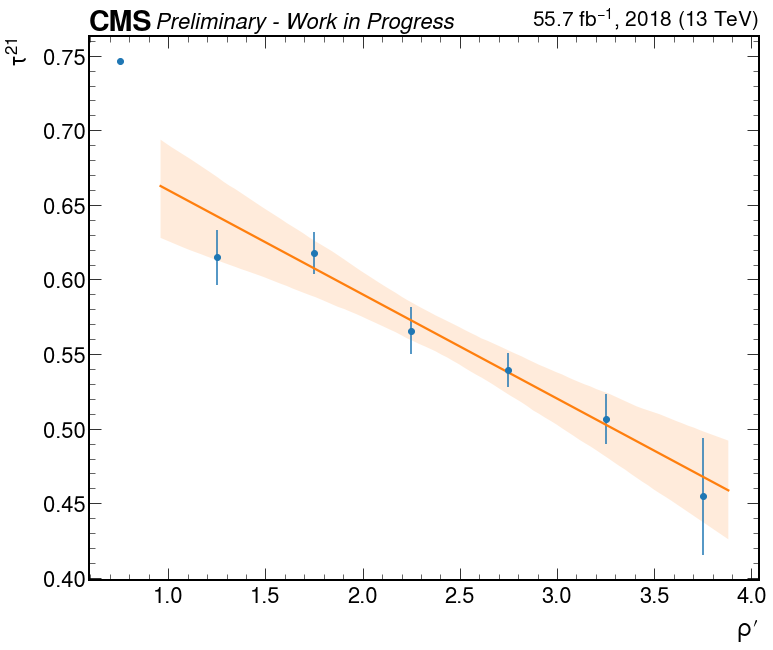

In [26]:
import seaborn as sns

def profile( x, y, bins, range ):
    binned_sums = scipy.stats.binned_statistic(x, [y, y**2], bins=bins, range=range, statistic='sum')
    print ( binned_sums )
    binned_counts = scipy.stats.binned_statistic(x, y, bins=bins, range=range, statistic='count')
    print ( binned_counts )

    bin_edges = binned_sums.bin_edges
    bin_centers = ( bin_edges[:-1] + bin_edges[1:] ) / 2

    sum_y_binned    = binned_sums.statistic[ 0 ]
    sum_y2_binned   = binned_sums.statistic[ 1 ]
    count_y_binned  = binned_counts.statistic
    print ( sum_y_binned, sum_y2_binned, count_y_binned )

    mean_y_binned  = ( sum_y_binned / count_y_binned )
    mean_y2_binned = ( sum_y2_binned / count_y_binned )
    stddev_binned  = np.sqrt( mean_y2_binned - mean_y_binned ** 2 )
    stddev_binned_ddof1 = stddev_binned * np.sqrt( count_y_binned ) / np.sqrt( count_y_binned - 1 )
    err_mean_y_binned = stddev_binned_ddof1 / np.sqrt( count_y_binned )
    print ( mean_y_binned, mean_y2_binned, stddev_binned, stddev_binned_ddof1, err_mean_y_binned )

    return ( bin_centers, mean_y_binned, stddev_binned_ddof1, err_mean_y_binned )

# Data
x = rhoprime1_QCD
y = jet0_tau21_QCD

bins = 100
range = (0.,50.)

bin_centers, mean_y_binned, stddev_binned_ddof1, err_mean_y_binned = profile( x, y, bins=bins, range=range )

fig = plt.figure( figsize=(12,10) )
plt.errorbar(x=bin_centers, y=mean_y_binned, yerr=err_mean_y_binned, linestyle='none', marker='o')
mplhep.cms.label('Preliminary - Work in Progress', data=True, lumi=55.7, year=2018, loc=0, fontsize=22)
plt.xlabel( r"$\rho\prime$" )
plt.ylabel( r"$\tau^{21}_{DDT}$" )
sns.regplot(x=x.rename(r"$\rho\prime$"), y=y.rename(r"$\tau^{21}$"), scatter=False)
slope, intercept, r, p, se = scipy.stats.linregress(x, y)
print(slope)
print(intercept)
if save_figures:
    if lepton_type == "muon":
        plt.savefig( "plots/slope_tau21_muon_2018.pdf", bbox_inches='tight' )
        plt.savefig( "plots/slope_tau21_muon_2018.png", bbox_inches='tight' )
    if lepton_type == "electron":
        plt.savefig( "plots/slope_tau21_electron_2018.pdf", bbox_inches='tight' )
        plt.savefig( "plots/slope_tau21_electron_2018.png", bbox_inches='tight' )